In [23]:
%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt

from datetime import datetime
import pandas as pd
import numpy as np

import warnings; warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from skgarden import RandomForestQuantileRegressor


plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [2]:
df = pd.read_csv("data_v2.csv")

In [3]:
df = df.rename({'KWH/hh (per half hour) ': 'KWh'}, axis=1)
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [4]:
df['hour'] = df.DateTime.dt.hour
df.head()

,LCLid,stdorToU,DateTime,KWh,Acorn,Acorn_grouped,hour
0,MAC000002,Std,2013-01-01 00:00:00,0.219,ACORN-A,Affluent,0
1,MAC000002,Std,2013-01-01 00:30:00,0.241,ACORN-A,Affluent,0
2,MAC000002,Std,2013-01-01 01:00:00,0.191,ACORN-A,Affluent,1
3,MAC000002,Std,2013-01-01 01:30:00,0.235,ACORN-A,Affluent,1
4,MAC000002,Std,2013-01-01 02:00:00,0.182,ACORN-A,Affluent,2


In [5]:
df['weekday'] = df.DateTime.dt.week

In [6]:
data = df.drop(['LCLid', 'stdorToU', 'Acorn', 'Acorn_grouped'], axis=1)

In [7]:
data = data.set_index(df.DateTime)

In [8]:
data.drop(['DateTime'], axis=1, inplace=True)

In [9]:
data.tail()

,KWh,hour,weekday
DateTime,,,
2013-12-31 21:30:00,0.089,21,1
2013-12-31 22:00:00,0.092,22,1
2013-12-31 22:30:00,0.059,22,1
2013-12-31 23:00:00,0.086,23,1
2013-12-31 23:30:00,0.086,23,1


In [16]:
h_params = {'n_in': 24 * 28, 'n_out': 24, 'step_foreward': 24, 'column_value': 'KWh'}

In [17]:
X_train = data[:h_params['n_in']][['hour', 'weekday']]
y_train = data[:h_params['n_in']][['KWh']]
X_train.shape

(672, 2)

In [18]:
rfqr = RandomForestQuantileRegressor(random_state=0)
rfqr.fit(X_train, y_train)
yHat_train = rfqr.predict(X_train)

In [19]:
def smape(yHat, y):
    return np.mean(np.abs((yHat - y) / (y + yHat))) * 100

In [20]:
print("SMAPE: ", smape(yHat_train, y_train.values))

SMAPE:  27.72926620434521


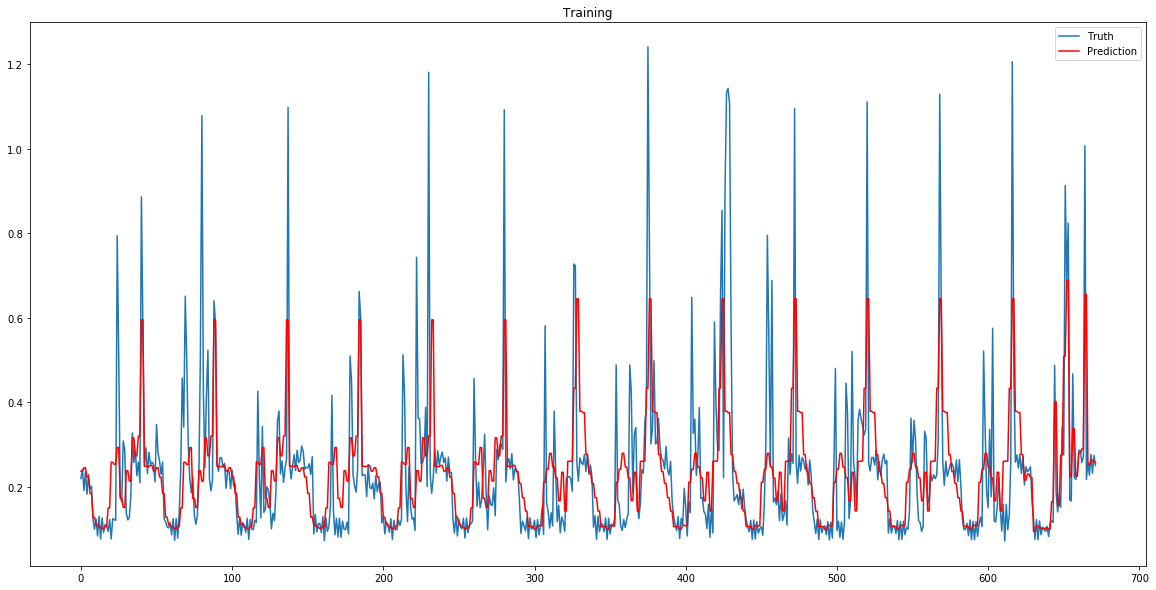

In [24]:
plt.plot(y_train['KWh'].values)
plt.plot(yHat_train, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.title("Training")
plt.show()

In [25]:
X_test = data[h_params['n_in']:(h_params['n_in'] + h_params['n_out'])][['hour', 'weekday']]
y_test = data[h_params['n_in']:(h_params['n_in'] + h_params['n_out'])][['KWh']]
yHat_test = rfqr.predict(X_test)
print("SMAPE: ", smape(yHat_test, y_test.values))

SMAPE:  24.52396214878495


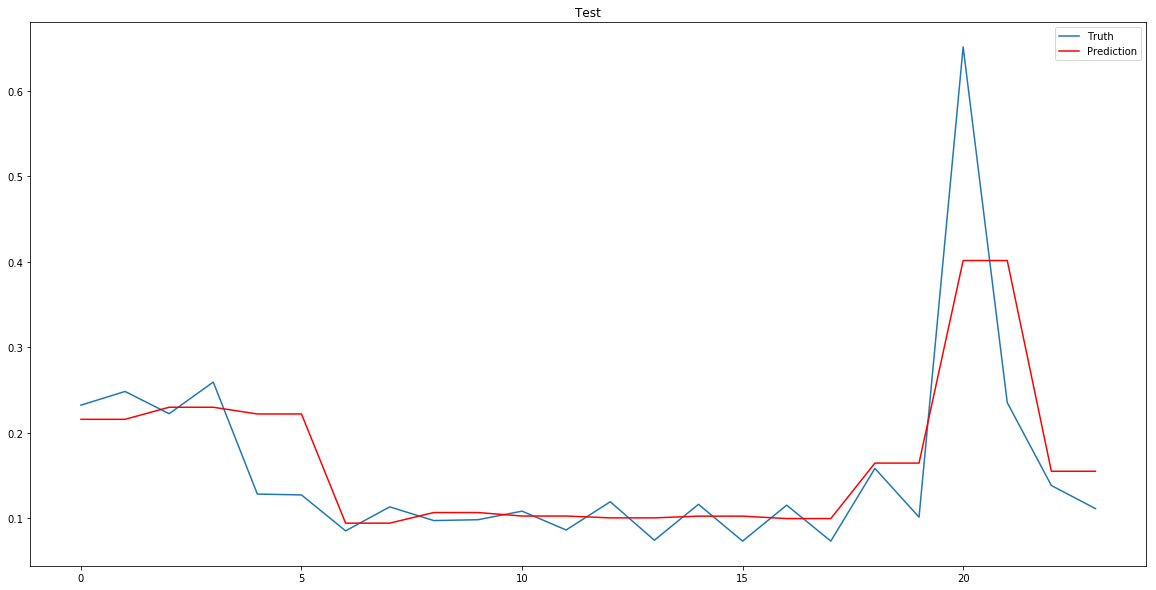

In [26]:
plt.plot(y_test['KWh'].values)
plt.plot(yHat_test, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.title("Test")
plt.show()

In [34]:
y = ['KWh']
features = ['hour', 'weekday']
n_in = h_params['n_in']
n_out = h_params['n_out']

In [ ]:
smape_values = rolling_forecast_experiment(data, y, features, n_in, n_out, n_out)
np.median(smape_values)

In [33]:
def prepare_train_test(df, y, features, n_in, n_out, current_step, step_foreward):
    step = current_step * step_foreward
    start_train = step
    end_train = n_in + step
    X_train = df[start_train:end_train][features]
    y_train = df[start_train:end_train][y]
    
    start_test = end_train
    end_test = start_test + n_out
    X_test = df[start_test:end_test][features]
    y_test = df[start_test:end_test][y]
    return X_train, y_train, X_test, y_test


def n_possible_steps(df, n_in, n_out, step_foreward):
    timesteps = df.shape[0]
    return int((timesteps - n_in - n_out) / step_foreward)


def rolling_forecast_experiment(df, y, features, n_in, n_out, step_foreward): 
    n_steps = n_possible_steps(df, n_in, n_out, step_foreward)
    
    smape_values = []
    for i in range(0, n_steps):
        rfqr = RandomForestQuantileRegressor(random_state=0)
        X_train, y_train, X_test, y_test = prepare_train_test(df, y, features, n_in, n_out, i, step_foreward)
        rfqr.fit(X_train, y_train)
        yHat = rfqr.predict(X_test)
        smape_values.append(smape(yHat, y_test.values))
    return smape_values